# calculate pearsons coefficients

In [50]:
import numpy as np
import pickle as pickle
import pandas as pd
from numpy import dot
from numpy.linalg import norm
import json
import sys
import seaborn as sb
import matplotlib.pyplot as plt
MAX_INT = sys.maxsize

In [51]:
KEYWORDS = ['gay', 'homosexual', 'lesbian', 'bisexual', 'queer', 'transgender']
PERSON = ["person", "human", "somebody"]
FEMALE = ["she", "daughter", "hers", "her", "mother", "woman", "girl", "herself", "female", "sister", 
        "daughters", "mothers", "women", "girls", "females", "sisters", "aunt", "aunts", "niece", "nieces"]
MALE = ["he", "son", "his", "him", "father", "man", "boy", "himself", "male", "brother", 
        "sons", "fathers", "men", "boys", "males", "brothers", "uncle", "uncles", "nephew", "nephews"]

In [52]:
def euclideanDistance(v1, v2):
    if v1 == 0 or v2 == 0:
        return MAX_INT
    
    n1 = np.array(v1)
    n2 = np.array(v2)
    
    return (sum(np.square(n1-n2))) ** 0.5

In [53]:
def findNearestNeighbors(vec, dataframe, k):
    distances = [(euclideanDistance(vec, list(row)), index) for index,row in dataframe.iterrows()]
    return [v for k,v in sorted(distances)[:k]]

In [54]:
# year, word = keyword,embed = lemmas or words
def outputNN(year, word, pairs, embed, regAdj = False):
    assert embed == 'lemmas' or embed == 'words'
    
    # load dataframe
    with open('sgns-' + embed + '/'+str(year)+'-vocab.pkl', 'rb') as f:
        vocab = pickle.load(f)
        #print(np.shape(vocab))
    filename = ('sgns-' + embed + '/'+str(year)+'-w.npy')
    vecs = np.load(filename)
    #print(np.shape(vecs))
   
    df = pd.DataFrame(vecs, index=vocab)
    df = df[df[0] != 0] # drop all vectors that are too small to carry meaning
    
    if word not in df.index:
        return pd.DataFrame([None])
    
    wordVec = list(df.loc[word])
    
    # calculate average vector of pairs
    groupWords = [a for a in pairs if a in df.index]

    avgVec = [a + b for a, b in zip(list(df.loc[groupWords[0]]), list(df.loc[groupWords[1]]))]
    for pair in groupWords[2:]:
        #if pair in df. 
        avgVec = [a+b for a,b in zip(avgVec, list(df.loc[pair]))]
    avgVec = [a/(len(groupWords)) for a in avgVec]
    
    with open('coha-adj-' + embed +'.txt') as file:
    #with open('adjectives.txt') as file:
        adjList = file.readlines() 
    adjList = [a.strip() for a in adjList]
    
    if regAdj:
        with open('adjectives.txt') as file:
            adjList = file.readlines() 
    adjList = [a.strip() for a in adjList]
    
    df = df[df.index.isin(adjList)] # filter so only adjectives remain in dataframe
    
    # calculate distance of keyword to adjectives
    dfDist = pd.DataFrame(columns=['distKey', 'distAvg'])
    
    for index, row in df.iterrows():
        dfDist.loc[index] = [euclideanDistance(wordVec, list(row)), euclideanDistance(avgVec, list(row))]
    
    dfDist['bias'] = dfDist['distKey'] - dfDist['distAvg'] # positive bias = closer to avg, negative bias = closer to key
    
    dfDist = dfDist['bias'].to_frame()
    
    return dfDist.sort_values('bias', ascending=False)

In [55]:
def getPlot(keyword):
    dfFull = pd.DataFrame()
    for year in range(1810, 2001, 10):
        df = (outputNN(year, keyword, PERSON+FEMALE+MALE, 'lemmas', regAdj=True)).rename(columns={'bias':year})
        dfFull = pd.concat([dfFull, df], axis=1)
    pearsoncorr = dfFull.corr(method='pearson')
    sb.set(rc = {'figure.figsize':(20,12)})
    ax = plt.axes()
    sb.heatmap(pearsoncorr, 
                xticklabels=pearsoncorr.columns,
                yticklabels=pearsoncorr.columns,
                #cmap='RdBu_r',
                cmap='mako',
                annot=True,
                linewidth=0.5)
    ax.set_title(keyword)
    plt.show()

ValueError: zero-size array to reduction operation fmin which has no identity

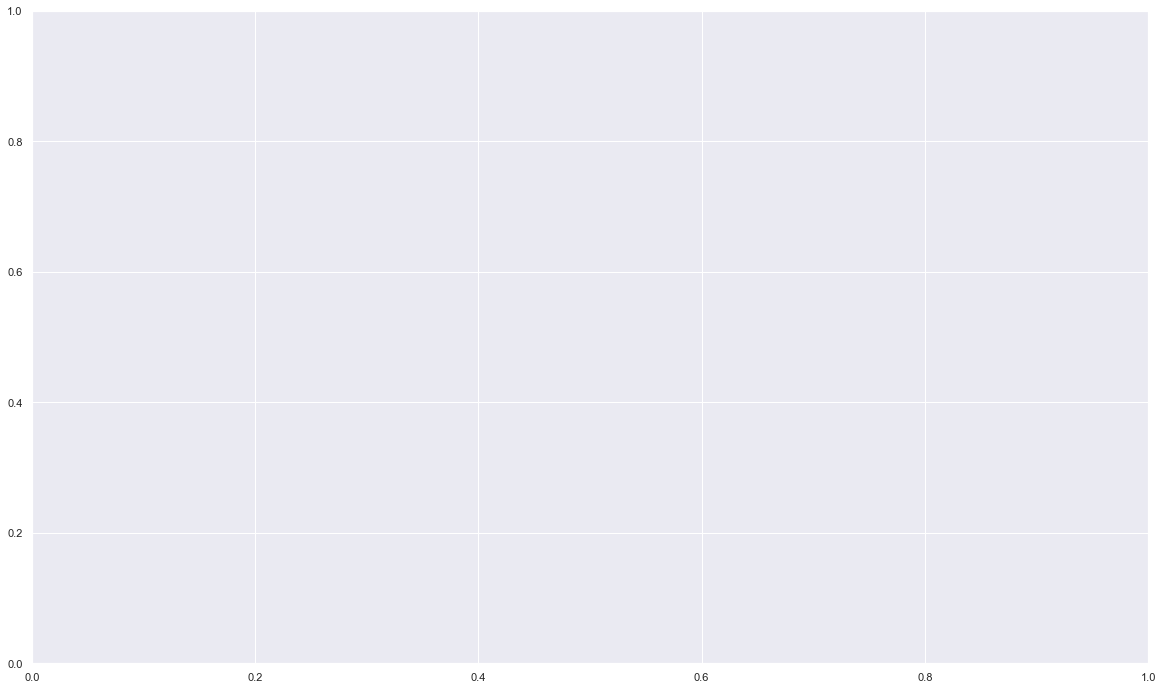

In [59]:
getPlot('sodomy')

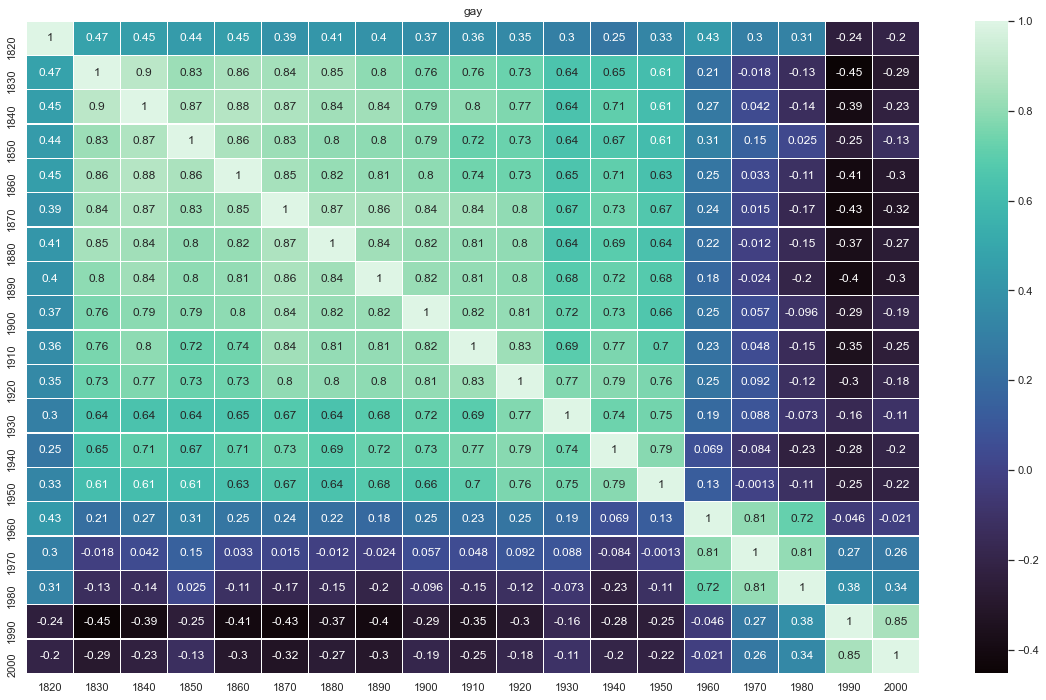

In [43]:
getPlot('gay')

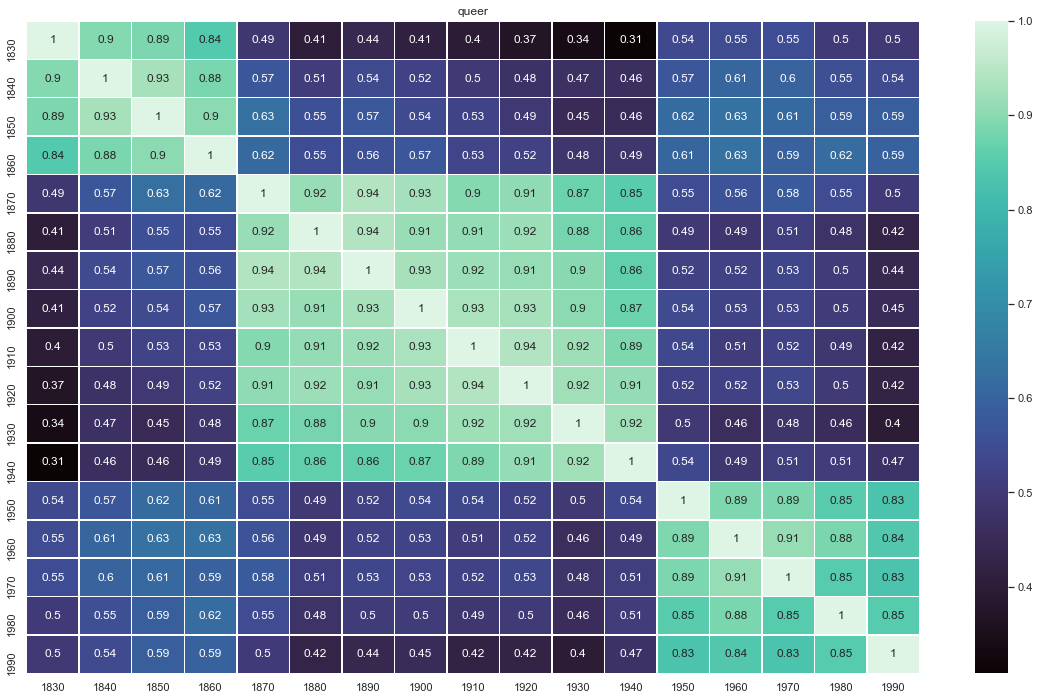

In [46]:
getPlot('queer')

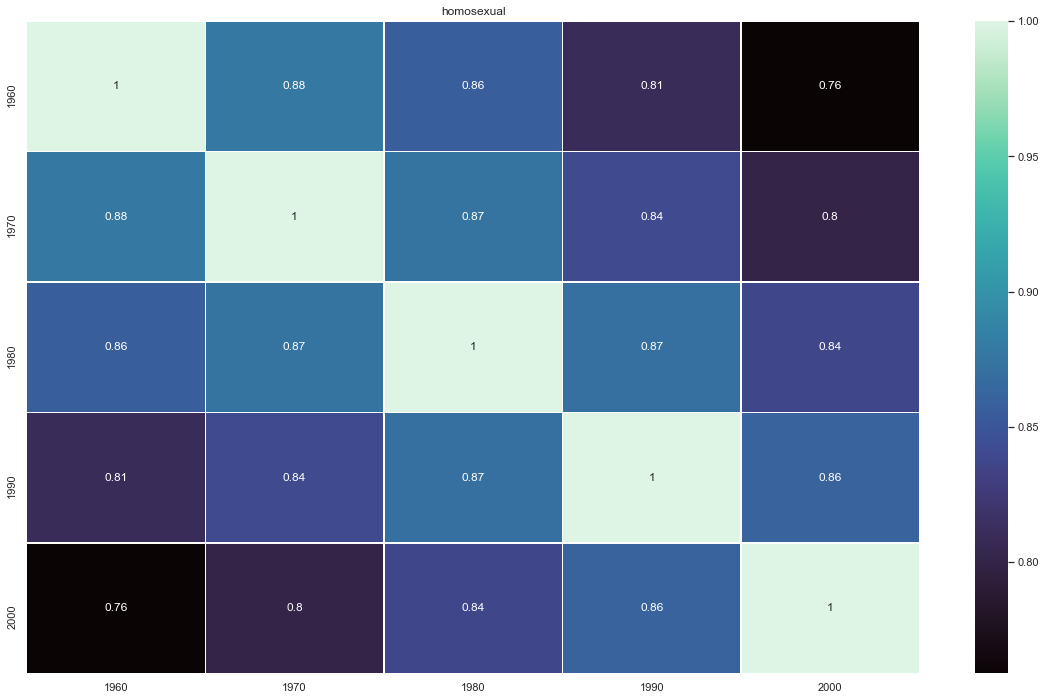

In [48]:
getPlot('homosexual')

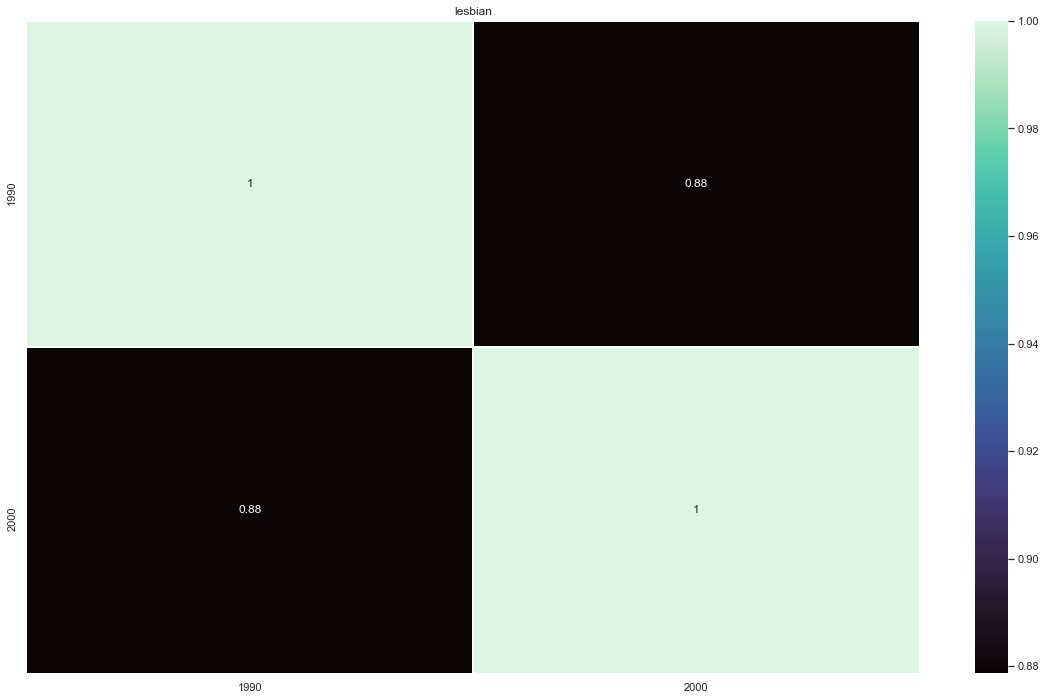

In [49]:
getPlot('lesbian')